# 요구사항1

In [21]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split

In [22]:
class TitanicDataset(Dataset):
  # 생성자
  def __init__(self, X, y):
    # input데이터를 X, answer데이터를 y에 저장한다.
    self.X = torch.FloatTensor(X) # 각각 FloatTensor
    self.y = torch.LongTensor(y) # LongTensor로 저장한다.

  # len() 함수
  def __len__(self):
    return len(self.X)

  # 인덱스 함수
  def __getitem__(self, idx):
    feature = self.X[idx]
    target = self.y[idx]
    return {'input': feature, 'target': target}

  # print함수
  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str

In [23]:
class TitanicTestDataset(Dataset):
  # 생성자
  def __init__(self, X):
    # input데이터를 X에 FloatTensor로 저장한다.
    self.X = torch.FloatTensor(X)

  # len함수
  def __len__(self):
    return len(self.X)

  # 인덱스 함수
  def __getitem__(self, idx):
    feature = self.X[idx]
    return {'input': feature}

  # print함수
  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}".format(
      len(self.X), self.X.shape
    )
    return str

In [24]:
def get_preprocessed_dataset():
    # 현재 파일 경로 설정
    # CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
    CURRENT_FILE_PATH = ""
    
    # train_data와 test_data의 경로 선언
    train_data_path = os.path.join(CURRENT_FILE_PATH, "train.csv")
    test_data_path = os.path.join(CURRENT_FILE_PATH, "test.csv")

    # train_data을 pandas.dataframe으로 변환
    train_df = pd.read_csv(train_data_path)
    # test_data를 pandas.dataframe으로 변환
    test_df = pd.read_csv(test_data_path)

    # all_df에 train_df와 test_df의 concat 결과를 저장한다.
    all_df = pd.concat([train_df, test_df], sort=False)

    # all_df의 Fare결측치를 메운다.
    all_df = get_preprocessed_dataset_1(all_df)
    # all_df의 name을 세 개의 column으로 나눈다
    all_df = get_preprocessed_dataset_2(all_df)
    # all_df의 Age 결측치를 메운다
    all_df = get_preprocessed_dataset_3(all_df)
    # all_df에 family_num 칼럼을 추가한다
    all_df = get_preprocessed_dataset_4(all_df)
    # all_df의 honorific값의 종류를 줄이고 Embarked의 결측치를 missing으로 메운다.
    all_df = get_preprocessed_dataset_5(all_df)
    # object인 값을 인코딩하여 정수로 변환한다.
    all_df = get_preprocessed_dataset_6(all_df)

    # all_df에서 "Survived"의 값이 비어있지 않은 경우 "Survived"열을 제거하고, 인덱스 번호를 새롭게 초기화하여 train_X에 대입한다.
    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    # train_df에서 "Survived"열만 train_y에 대입한다.
    train_y = train_df["Survived"]

    # all_df에서 "Survived"의 값이 비어있는 경우 "Survived"열을 제거하고, 인덱스 번호를 새롭게 초기화 하여 test_X에 대입한다.
    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

    # TitanicDataset클래스 객체를 생성한다. 이때, train_X.values와 train_y.values를 생성자에게 넘겨준다.
    dataset = TitanicDataset(train_X.values, train_y.values)
    #print(dataset)
    # 생성된 dataset을 8:2로 나누어 train_dataset과 validation_dataset 두 개로 랜덤하게 분리한다.
    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
    # TitanicTestDataset클래스 객체를 생성한다. 이때 test_X.values를 생성자에게 넘겨준다.
    test_dataset = TitanicTestDataset(test_X.values)
    #print(test_dataset)

    # 생성된 train_dataset, validation_dataset, test_dataset을 반환한다.
    return train_dataset, validation_dataset, test_dataset

In [25]:
def get_preprocessed_dataset_1(all_df):
    # Pclass별 Fare 평균값을 사용하여 Fare 결측치 메우기
    # 인자로 전달받은 DataFrame에서, Pclass, Fare값에 대하여, Pclass값을 기준으로 grouping을 한 후, 평균값을 구하여 인덱스를 초기화한다.
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    # Fare_mean의 columns 이름을 "Pclass", "Fare_mean"으로 변경한다.
    Fare_mean.columns = ["Pclass", "Fare_mean"]
    # all_df와 Fare_mean을 merge하는데, "Pclass"에 대하여 left(all_df)로 merge한다.
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    # all_df의 "Fare"값들 중 Nan 또는 None 값인 인덱스만 찾아서 all_df["Fare_mean"]값으로 변경한다.
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]

    # 해당 결과를 반환한다.
    return all_df

In [26]:
def get_preprocessed_dataset_2(all_df):
    # name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
    # 인자로 전달받은 all_df에서 "Name"열을 찾아 split한다.
    # 이때, 콤마(,)와 닷(.)을 기준으로 split하며, split은 구분자를 기준으로 최대 2번까지로 설정한다.
    # expand를 True로 설정하여 열을 확장하도록 한다.
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    # 열 이름을 "family_name", "honorific", "name"으로 설정한다.
    name_df.columns = ["family_name", "honorific", "name"]
    # name_df["family_name"]의 모든 값을 strip하여 양 끝의 공백을 제거한다.
    name_df["family_name"] = name_df["family_name"].str.strip()
    # name_df["honorific"]의 모든 값을 strip하여 양 끝의 공백을 제거한다.
    name_df["honorific"] = name_df["honorific"].str.strip()
    # name_df["name"]의 모든 값을 strip하여 양 끝의 공백을 제거한다.
    name_df["name"] = name_df["name"].str.strip()
    # pandas.concat함수를 이용하여 all_df와 name_df를 열 방향으로 합친다.
    all_df = pd.concat([all_df, name_df], axis=1)
    
    # 결과값을 반환한다.
    return all_df

In [27]:
def get_preprocessed_dataset_3(all_df):
    # honorific별 Age 평균값을 사용하여 Age 결측치 메우기
    # 매개변수로 전달받은 all_df의 honorific"을 기준으로 grouping을 해준 뒤, Age의 중간값을 찾아 반올림 하고 인덱스를 초기화한다.
    honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").median().round().reset_index()
    # 각 열의 이름을 "honorific", "honorific_age_mean"으로 설정한다.
    honorific_age_mean.columns = ["honorific", "honorific_age_mean", ]
    # all_df에 위에서 구한 mean값을 honorific을 기준으로 merge한다.
    all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
    # all_df의 Age가 None 또는 Nan인 "Age" 인덱스를 찾아서 all_df의 honorific_age_mean값을 대입한다.
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_age_mean"]
    # all_df의 "honorific_age_mean" 열을 drop한다.
    all_df = all_df.drop(["honorific_age_mean"], axis=1)

    # 결과값을 리턴한다.
    return all_df

In [28]:
def get_preprocessed_dataset_4(all_df):
    # 가족수(family_num) 컬럼 새롭게 추가
    # 함께 탑승한 Parch(부모와 자식), Sibsp(형제자매와 배우자)를 더하여 family_num의 값으로 한다.
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

    # 혼자탑승(alone) 컬럼 새롭게 추가
    # family_num의 값이 0인 경우 "alone"행을 추가하여 1로 설정한다.
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    # 위에서 추가한 alone 열의 결측값을 전부 0으로 채운다.
    all_df["alone"].fillna(0, inplace=True)

    # 학습에 불필요한 컬럼 제거
    # passengerid, name, family_name, name, ticket, cabin을 열을 기준으로 제거한다.
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

    # 해당 결과값을 반환한다.
    return all_df

In [29]:
def get_preprocessed_dataset_5(all_df):
    # honorific 값 개수 줄이기
    # honorific이 Mr, Miss, Mrs, Master가 아닌 경우, honorific의 값을 other로 통일한다.
    all_df.loc[
    ~(
            (all_df["honorific"] == "Mr") |
            (all_df["honorific"] == "Miss") |
            (all_df["honorific"] == "Mrs") |
            (all_df["honorific"] == "Master")
    ),
    "honorific"
    ] = "other"
    # all_df의 "Embarked"의 결측치를 "missing"으로 변경한다.
    all_df["Embarked"].fillna("missing", inplace=True)

    # 결과값을 반환한다.
    return all_df

In [30]:
def get_preprocessed_dataset_6(all_df):
    # 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
    # 매개변수로 전달받은 all_df에서 dtype이 "object"인 열의 이름들만 추출하여 category_features에 저장한다.
    category_features = all_df.columns[all_df.dtypes == "object"]
    
    # LabelEncoder를 import한다. 각 값을 정수로 인덱싱 하기 위해 사용한다.
    from sklearn.preprocessing import LabelEncoder
    
    # category_features의 값을 하나씩 가져와 category_feature에 대입하며 반복한다.
    for category_feature in category_features:
        # LabelEncoder 객체를 le에 대입한다.
        le = LabelEncoder()
        # all_df의 값 중 all_df[category_feature]의 dtype이 object인 경우
        if all_df[category_feature].dtypes == "object":
          # LabelEncoder를 이용하여 인덱스 값을 추출한 후
          le = le.fit(all_df[category_feature])
          # all_df[category_feature]의 값을 해당 인덱스 값으로 변경한다.
          all_df[category_feature] = le.transform(all_df[category_feature])

# 질문:
# 맨 위에서 all_df.dtype == "object"로 이미 dtype이 "object"인 것만 category_features에 저장했는데,
# 아래의 for문 내부에서 if 조건문을 이용하여 dtype을 검사하는지 궁금합니다.
            
    # 결과를 반환한다.
    return all_df

In [31]:
from torch import nn

In [32]:
class MyModel(nn.Module):
  # input, output의 개수를 생성자에 넘겨줌
  def __init__(self, n_input, n_output):
    super().__init__()

    # model을 nn.Sequential을 이용하여 정의함
    self.model = nn.Sequential(
      nn.Linear(n_input, 30), # nn.Linear을 이용하여 n_input만큼 대입하고, 30만큼 결과값을 내보내는 레이어를 만든다
      nn.ReLU(), # ReLU함수에 대입함
      nn.Linear(30, 30), # nn.Linear을 이용하여 30만큼 대입하고 30만큼 결과값을 내보내는 레이어를 만든다
      nn.ReLU(), # ReLU함수에 대입함
      nn.Linear(30, n_output), # nn.Linear을 이용하여 30만큼 대입하고 n_output만큼 결과값을 내보내는 레이어를 만든다
    )

  # forward함수 정의
  def forward(self, x):
    # self.model에 x값을 대입한 결과를 반환함
    x = self.model(x)
    return x

In [33]:
def test(test_data_loader):
  print("[TEST]")
  batch = next(iter(test_data_loader)) # test_data_loader에서 데이터를 가져와 batch에 대입한다.
  print("{0}".format(batch['input'].shape))
  # MyModel객체를 생성한다. 이때 input은 11, output은 2로 한다. 11은 batch의 column개수이고 2는 사망 여부를 나타내는 0과 1이다.
  my_model = MyModel(n_input=11, n_output=2)
  # output_batch에 my_model의 forward함수 호출 결과를 저장한다.
  output_batch = my_model(batch['input'])
  # output_batch의 값중 가장 큰 값을 선택하여 prediction_batch에 저장한다.
  # 이때 dim=1로 하여 output_batch의 1번 차원의 값 중 하나를 선택한다.
  prediction_batch = torch.argmax(output_batch, dim=1)
  for idx, prediction in enumerate(prediction_batch, start=892):
      print(idx, prediction.item())

In [34]:
if __name__ == "__main__":
  # get_preprocessed_dataset()함수를 이용하여 미리 전처리된 데이터셋을 받아온다.
  train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

  # 각 데이터셋의 길이를 출력한다.
  print("train_dataset: {0}, validation_dataset.shape: {1}, test_dataset: {2}".format(
    len(train_dataset), len(validation_dataset), len(test_dataset)
  ))
  print("#" * 50, 1)

  # train_datset의 input값과 target값을 출력한다.
  for idx, sample in enumerate(train_dataset):
    print("{0} - {1}: {2}".format(idx, sample['input'], sample['target']))

  print("#" * 50, 2)

  # train_data_loader, validation_data_loader, test_data_loader를 DataLoader객체를 이용하여 생성한다.
  # 이때 train_data_loader, validation_data_loader의 경우 shuffle=True 그리고 batch_size=16으로 한다.
  train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
  validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=16, shuffle=True)
  # test_data_loader는 shuffle하지 않고, batch_size=len(test_dataset으로 한다.
  test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

  # train_data_loader의 input.shape과 target.shape을 출력한다.
  print("[TRAIN]")
  for idx, batch in enumerate(train_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  # validation_data_loader의 input.shape과 target.shape을 출력한다.
  print("[VALIDATION]")
  for idx, batch in enumerate(validation_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("#" * 50, 3)

  # test_data_loader을 test함수의 인자로 전달하여 test함수를 호출한다.
  test(test_data_loader)


train_dataset: 713, validation_dataset.shape: 178, test_dataset: 418
################################################## 1
0 - tensor([ 2.0000,  1.0000, 25.0000,  1.0000,  0.0000, 26.0000,  2.0000, 21.1792,
         2.0000,  1.0000,  0.0000]): 0
1 - tensor([ 3.0000,  0.0000, 26.0000,  1.0000,  0.0000, 16.1000,  2.0000, 13.3029,
         3.0000,  1.0000,  0.0000]): 0
2 - tensor([ 2.0000,  1.0000, 36.5000,  0.0000,  2.0000, 26.0000,  2.0000, 21.1792,
         2.0000,  2.0000,  0.0000]): 0
3 - tensor([ 3.0000,  1.0000, 24.0000,  0.0000,  0.0000,  8.0500,  2.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0
4 - tensor([ 2.0000,  0.0000, 36.0000,  1.0000,  0.0000, 26.0000,  2.0000, 21.1792,
         3.0000,  1.0000,  0.0000]): 1
5 - tensor([ 3.0000,  1.0000, 21.0000,  0.0000,  0.0000,  7.7333,  1.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0
6 - tensor([ 2.0000,  1.0000, 23.0000,  2.0000,  1.0000, 11.5000,  2.0000, 21.1792,
         2.0000,  3.0000,  0.0000]): 0
7 - tensor([  1.0

353 - tensor([ 3.0000,  1.0000, 33.0000,  0.0000,  0.0000,  8.6625,  0.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0
354 - tensor([ 3.0000,  1.0000, 29.0000,  0.0000,  0.0000, 14.5000,  2.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0
355 - tensor([ 3.0000,  0.0000,  4.0000,  0.0000,  2.0000, 22.0250,  2.0000, 13.3029,
         1.0000,  2.0000,  0.0000]): 1
356 - tensor([ 3.0000,  1.0000, 55.5000,  0.0000,  0.0000,  8.0500,  2.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0
357 - tensor([ 2.0000,  0.0000, 22.0000,  0.0000,  0.0000, 12.3500,  1.0000, 21.1792,
         1.0000,  0.0000,  1.0000]): 1
358 - tensor([ 3.0000,  0.0000, 22.0000,  1.0000,  2.0000, 23.4500,  2.0000, 13.3029,
         1.0000,  3.0000,  0.0000]): 0
359 - tensor([ 2.0000,  1.0000, 42.0000,  0.0000,  0.0000, 13.0000,  2.0000, 21.1792,
         4.0000,  0.0000,  1.0000]): 0
360 - tensor([ 3.0000,  1.0000, 29.0000,  0.0000,  0.0000,  8.7125,  0.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0


[TRAIN]
0 - torch.Size([16, 11]): torch.Size([16])
1 - torch.Size([16, 11]): torch.Size([16])
2 - torch.Size([16, 11]): torch.Size([16])
3 - torch.Size([16, 11]): torch.Size([16])
4 - torch.Size([16, 11]): torch.Size([16])
5 - torch.Size([16, 11]): torch.Size([16])
6 - torch.Size([16, 11]): torch.Size([16])
7 - torch.Size([16, 11]): torch.Size([16])
8 - torch.Size([16, 11]): torch.Size([16])
9 - torch.Size([16, 11]): torch.Size([16])
10 - torch.Size([16, 11]): torch.Size([16])
11 - torch.Size([16, 11]): torch.Size([16])
12 - torch.Size([16, 11]): torch.Size([16])
13 - torch.Size([16, 11]): torch.Size([16])
14 - torch.Size([16, 11]): torch.Size([16])
15 - torch.Size([16, 11]): torch.Size([16])
16 - torch.Size([16, 11]): torch.Size([16])
17 - torch.Size([16, 11]): torch.Size([16])
18 - torch.Size([16, 11]): torch.Size([16])
19 - torch.Size([16, 11]): torch.Size([16])
20 - torch.Size([16, 11]): torch.Size([16])
21 - torch.Size([16, 11]): torch.Size([16])
22 - torch.Size([16, 11]): torch.S

# 요구사항 2

In [4]:
pip install wandb

  Using cached wandb-0.15.12-py3-none-any.whl (2.1 MB)
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl (9.0 kB)
     -------------------------------------- 430.5/430.5 kB 8.9 MB/s eta 0:00:00
  Using cached GitPython-3.1.37-py3-none-any.whl (190 kB)
  Using cached sentry_sdk-1.32.0-py2.py3-none-any.whl (240 kB)
  Using cached pathtools-0.1.2.tar.gz (11 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached gitdb-4.0.10-py3-none-any.whl (62 kB)
  Using cached smmap-5.0.1-py3-none-any.whl (24 kB)
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8792 sha256=96a67c88fa64e2a7ef9c4cc997748dc9276544b6bd2c4685376b44f78ec3cb05
  Stored in directory: c:\users\volca\appdata\local\pip\cache\wheels\b7\0a\67\ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools
Note: you may need to restart the kernel to use updated packages.


In [26]:
import torch
from torch import nn, optim
from torch.utils.data import random_split, DataLoader, Dataset
from datetime import datetime
import wandb
import argparse
import pandas as pd
import os

In [9]:
class TitanicDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X)
    self.y = torch.LongTensor(y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    feature = self.X[idx]
    target = self.y[idx]
    return {'input': feature, 'target': target}

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str

In [10]:
class TitanicTestDataset(Dataset):
  def __init__(self, X):
      self.X = torch.FloatTensor(X)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, idx):
      feature = self.X[idx]
      return {'input': feature}

  def __str__(self):
      str = "Data Size: {0}, Input Shape: {1}".format(
          len(self.X), self.X.shape
      )
      return str

In [11]:
def get_preprocessed_dataset():
    CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))

    train_data_path = os.path.join(CURRENT_FILE_PATH, "train.csv")
    test_data_path = os.path.join(CURRENT_FILE_PATH, "test.csv")

    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)

    all_df = pd.concat([train_df, test_df], sort=False)
    all_df = get_preprocessed_dataset_1(all_df)
    all_df = get_preprocessed_dataset_2(all_df)
    all_df = get_preprocessed_dataset_3(all_df)
    all_df = get_preprocessed_dataset_4(all_df)
    all_df = get_preprocessed_dataset_5(all_df)
    all_df = get_preprocessed_dataset_6(all_df)

    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    train_y = train_df["Survived"]

    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

    dataset = TitanicDataset(train_X.values, train_y.values)
    test_dataset = TitanicTestDataset(test_X.values)
    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])

    return train_dataset, validation_dataset, test_dataset

In [12]:
def get_preprocessed_dataset_1(all_df):
    # Pclass별 Fare 평균값을 사용하여 Fare 결측치 메우기
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    Fare_mean.columns = ["Pclass", "Fare_mean"]
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]
    return all_df

In [13]:
def get_preprocessed_dataset_2(all_df):
    # name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    name_df.columns = ["family_name", "honorific", "name"]
    name_df["family_name"] = name_df["family_name"].str.strip()
    name_df["honorific"] = name_df["honorific"].str.strip()
    name_df["name"] = name_df["name"].str.strip()
    all_df = pd.concat([all_df, name_df], axis=1)

    return all_df

In [14]:
def get_preprocessed_dataset_3(all_df):
    # honorific별 Age 평균값을 사용하여 Age 결측치 메우기
    honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").median().round().reset_index()
    honorific_age_mean.columns = ["honorific", "honorific_age_mean", ]
    all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_age_mean"]
    all_df = all_df.drop(["honorific_age_mean"], axis=1)

    return all_df

In [15]:
def get_preprocessed_dataset_4(all_df):
    # 가족수(family_num) 컬럼 새롭게 추가
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

    # 혼자탑승(alone) 컬럼 새롭게 추가
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    all_df["alone"].fillna(0, inplace=True)

    # 학습에 불필요한 컬럼 제거
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

    return all_df

In [16]:
def get_preprocessed_dataset_5(all_df):
    # honorific 값 개수 줄이기
    all_df.loc[
    ~(
            (all_df["honorific"] == "Mr") |
            (all_df["honorific"] == "Miss") |
            (all_df["honorific"] == "Mrs") |
            (all_df["honorific"] == "Master")
    ),
    "honorific"
    ] = "other"
    all_df["Embarked"].fillna("missing", inplace=True)

    return all_df

In [17]:
def get_preprocessed_dataset_6(all_df):
    # 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
    category_features = all_df.columns[all_df.dtypes == "object"]
    from sklearn.preprocessing import LabelEncoder
    for category_feature in category_features:
        le = LabelEncoder()
        if all_df[category_feature].dtypes == "object":
            le = le.fit(all_df[category_feature])
            all_df[category_feature] = le.transform(all_df[category_feature])
    return all_df

In [18]:
class MyModel(nn.Module):
  def __init__(self, n_input, n_output, func):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]),
        func(),
        nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),
        func(),
        nn.Linear(wandb.config.n_hidden_unit_list[1], n_output),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    x = self.model(x)
    return x

In [19]:
def get_model_and_optimizer(f):
  my_model = MyModel(n_input=11, n_output=2, func=f)
  optimizer = optim.SGD(my_model.parameters(), lr=wandb.config.learning_rate)

  return my_model, optimizer

In [20]:
def training_loop(model, optimizer, train_data_loader, validation_data_loader):
  n_epochs = wandb.config.epochs
  loss_fn = nn.CrossEntropyLoss()  # Use a built-in loss function
  next_print_epoch = 100
  best_validation_loss = float('inf')
  patience = int(n_epochs * 0.1)
  no_improvement = 0
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    num_trains = 0
    for train_batch in train_data_loader:
      output_train = model(train_batch['input'])
      loss = loss_fn(output_train, train_batch['target'])
      loss_train += loss.item()
      num_trains += 1

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    loss_validation = 0.0
    num_validations = 0
    with torch.no_grad():
      for validation_batch in validation_data_loader:
        output_validation = model(validation_batch['input'])
        loss = loss_fn(output_validation, validation_batch['target'])
        loss_validation += loss.item()
        num_validations += 1

    if loss_validation < best_validation_loss:
        best_validation_loss = loss_validation
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print(f'Early stopping after {epoch + 1} epochs.')
        break

    wandb.log({
      "Epoch": epoch,
      "Training loss": loss_train / num_trains,
      "Validation loss": loss_validation / num_validations,
    })

    if epoch >= next_print_epoch:
      print(
        f"Epoch {epoch}, "
        f"Training loss {loss_train / num_trains:.4f}, "
        f"Validation loss {loss_validation / num_validations:.4f}, "
      )
      next_print_epoch += 100

In [21]:
def main(args):
    for func in [nn.ReLU, nn.PReLU, nn.ELU, nn.LeakyReLU]:
        current_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
        for i in range(1):
          config = {
            'epochs': args.epochs,
            'batch_size': args.batch_size,
            'learning_rate': 1e-3,
            'n_hidden_unit_list': [20, 20],
          }

          wandb.init(
            mode="online" if args.wandb else "disabled",
            project= func.__name__ + current_time_str,
            # project="my_model_training " + current_time_str,
            notes=func.__name__ + " performance",
            tags=["my_model", "titanic"],
            name=func.__name__ + " " + current_time_str,
            config=config
          )
          print(args)
          print(wandb.config)

          train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

          train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
          validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=16, shuffle=True)
          test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

          linear_model, optimizer = get_model_and_optimizer(func)

          wandb.watch(linear_model)

          print("#" * 50, i, func.__name__)

          training_loop(
            model=linear_model,
            optimizer=optimizer,
            train_data_loader=train_data_loader,
            validation_data_loader=validation_data_loader
          )

          batch = next(iter(test_data_loader))
          output_batch = linear_model(batch['input'])
          prediction_batch = torch.argmax(output_batch, dim=1)
          result = pd.DataFrame(prediction_batch, columns=['Survived'])
          result['PassengerId'] = [i for i in range(892, 1310)]
          result = result[['PassengerId', 'Survived']]
          result.to_csv("submission.csv", index=False)
          wandb.finish()

In [41]:
# if __name__ == "__main__":
#         parser = argparse.ArgumentParser()

#         parser.add_argument(
#             "--wandb", action=argparse.BooleanOptionalAction, default=False, help="True or False"
#         )

#         parser.add_argument(
#             "--batch_size", type=int, default=512, help="Batch size (int, default: 512)"
#         )

#         parser.add_argument(
#             "--epochs", type=int, default=1_000, help="Number of training epochs (int, default:1_000)"
#         )

#         args = parser.parse_args()

#         main(args)
# jupyter notebook 에서 argparser를 사용하기 힘들어 주석처리.

In [47]:
!python hw2_titanic_2021136124.py --wandb --epochs 1000 --batch_size 512

Namespace(wandb=True, batch_size=512, epochs=1000)
{'epochs': 1000, 'batch_size': 512, 'learning_rate': 0.001, 'n_hidden_unit_list': [20, 20]}
################################################## 0 ReLU
Epoch 100, Training loss 0.5751, Validation loss 0.6157, 
Early stopping after 168 epochs.
Namespace(wandb=True, batch_size=512, epochs=1000)
{'epochs': 1000, 'batch_size': 512, 'learning_rate': 0.001, 'n_hidden_unit_list': [20, 20]}
################################################## 0 PReLU
Epoch 100, Training loss 0.5947, Validation loss 0.5889, 
Epoch 200, Training loss 0.5865, Validation loss 0.5771, 
Epoch 300, Training loss 0.5831, Validation loss 0.6247, 
Epoch 400, Training loss 0.5813, Validation loss 0.5550, 
Epoch 500, Training loss 0.5778, Validation loss 0.5540, 
Epoch 600, Training loss 0.5752, Validation loss 0.5638, 
Epoch 700, Training loss 0.5734, Validation loss 0.5528, 
Epoch 800, Training loss 0.5694, Validation loss 0.5860, 
Epoch 900, Training loss 0.5680, Validatio

wandb: Currently logged in as: volcano020716. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.12
wandb: Run data is saved locally in C:\Users\volca\link_dl\wandb\run-20231015_172225-ykppfjsr
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ReLU 2023-10-15_17-22-23
wandb:  View project at https://wandb.ai/volcano020716/ReLU2023-10-15_17-22-23
wandb:  View run at https://wandb.ai/volcano020716/ReLU2023-10-15_17-22-23/runs/ykppfjsr
wandb: Waiting for W&B process to finish... (success).
wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
wandb: \ 0.001 MB of 0.033 MB uploaded (0.000 MB deduped)
wandb: | 0.001 MB of 0.033 MB uploaded (0.000 MB deduped)
wandb: 
wandb: Run summary:
wandb:           Epoch 166
wandb:   Training loss 0.57188
wandb: Validation loss 0.61827
wandb: 
wandb:  View run ReLU 2023-10-15_17-22-23 at: https://wandb.ai/volcano020716/ReLU2023-10-15_17-22-23/runs/ykppfjsr
wandb: Synced 6 W&B file(s), 0 media fi

[ReLU training loss](https://api.wandb.ai/links/volcano020716/cpcfmyvm)<br>
[ReLU validation loss](https://api.wandb.ai/links/volcano020716/2gmcrjz2)

[PReLU training loss](https://api.wandb.ai/links/volcano020716/nclr5iw7)<br>
[PReLU validation loss](https://api.wandb.ai/links/volcano020716/qqrap4nu)

[ELU training loss](https://api.wandb.ai/links/volcano020716/7idzkpm1)<br>
[ELU validation loss](https://api.wandb.ai/links/volcano020716/hlhlehff)

[LeakyReLU training loss](https://api.wandb.ai/links/volcano020716/opdl32fz)<br>
[LeakyReLU validation loss](https://api.wandb.ai/links/volcano020716/76vwmvzl)

각 activation function마다 epoch의 차이가 생긴 이유는, training 과정에서 일정 epoch이상 validation loss가 개선되지 않으면 자동으로 training을 종료하도록 설정했기 때문이다.

이중 PReLU함수가 다른 3개의 함수보다 더 나은 성능을 산출한다고 생각하였다.

- 다른 activation function들은 training loss / validation loss 의 값이 일정하게 안정적으로 유지되지 않지만 PReLU의 경우 안정적인 상태가 유지된다고 생각했다.
- 다른 activation function보다 더 많은 epoch를 수행함으로 validation loss가 계속적으로 개선되었다고 생각했다.

# 요구사항 3

In [48]:
# 위의 요구사항 2 에서 가장 좋은 성능을 보이는 PReLU로 모델을 구성하면 다음과 같다.

class MyModel(nn.Module):
  def __init__(self, n_input, n_output, func):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]),
        nn.PReLU(),
        nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),
        nn.PReLU(),
        nn.Linear(wandb.config.n_hidden_unit_list[1], n_output),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    x = self.model(x)
    return x

epoch를 진행하면서, validation loss의 값의 개선이 일정 epoch 횟수 이상 일어나지 않으면, 해당 시점에서 training을 종료하고 test를 수행하는것이 좋은 방법인 것 같다.

validation loss 값의 개선이 일어나지 않는다는것은 해당 모델이 더이상 개선되지 않고 과적합이 될 가능성이 있다. 따라서 validation loss 값의 개선이 일어나지 않는다면 해당 시점에서 training을 종료하고 test를 수행하는 것이 바람직하다.

보통 전체 epoch의 10% ~ 20% 정도를 patience로 설정한다고 한다.

이를 반영하여 training 코드에 추가한다면 다음 코드가 작성될 수 있다.

```python
best_validation_loss = float('inf')
patience = int(n_epochs * 0.1)
no_improvement = 0
.
.
.
if loss_validation < best_validation_loss:
        best_validation_loss = loss_validation
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print(f'Early stopping after {epoch + 1} epochs.')
        break
```

submission.csv 내용

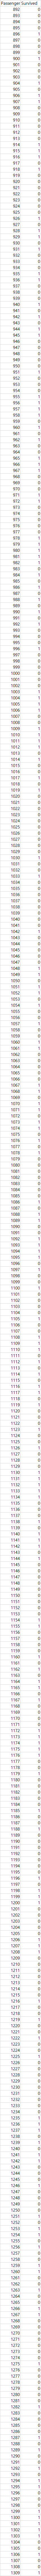

위의 submission.csv 제출 결과

![submission.csv](kaggle_result.png)

#### 숙제 후기

이번 과제를 진행하면서, 딥러닝 모델의 성능을 좌우하는것은 hidden layer와 unit만이 중요한 것이 아니라, train data, validation data, test data, 그리고 학습을 진행하는 epoch수, bash size 등 수많은 요인이 있다는 것을 알게 되었다. 처음에는 제공되는 data가 한정적인 상태에서 무작정 unit과 layer의 수를 늘려가며 테스트를 진행했지만 epoch도 모델의 성능을 좌우할 수 있는 하나의요인이라는 것을 알게 된 후로 epoch의 양을 조절하고 patience값을 설정하는 등 모델 학습의 성능을 개선하는 여러 방법들을 알게 되어 좋았다. 
